# SIR model

Here we calibrate a differentiable version of the SIR model.
We use the exact same model as  https://ndlib.readthedocs.io/en/latest/reference/models/epidemics/SIR.html,
but implemented in a differentiable way.

In [2]:
from birds.models.sir import SIR
from birds.calibrator import Calibrator

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx
import normflows as nf
import pygtc

## Generating synthetic true data

In [3]:
device = "cpu"

In [4]:
# generate a random graph
n_agents = 1000
graph = networkx.watts_strogatz_graph(n_agents, 10, 0.1)

In [5]:
sir = SIR(graph, n_timesteps=100, device=device)

In [6]:
%%time
# the simulator takes as parameters the log10 of the fraction of initial cases, beta, and gamma parameters
true_parameters = torch.log10(torch.tensor([0.05, 0.05, 0.05], device=device))
true_data = sir.run_and_observe(true_parameters)
true_infected, true_recovered = true_data

CPU times: user 46.5 ms, sys: 24 ms, total: 70.5 ms
Wall time: 52.2 ms


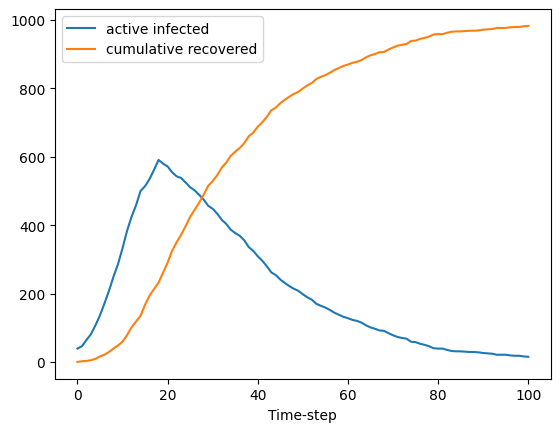

In [7]:
f, ax = plt.subplots()
ax.plot(true_infected.cpu(), label = "active infected")
ax.set_xlabel("Time-step")
ax.plot(true_recovered.cpu(), label = "cumulative recovered")
ax.legend()

## Approximating the posterior by a normalizing flow

We construct the flow using the normflows library (https://github.com/VincentStimper/normalizing-flows )

In this case we define Neural Spline Flow with 4 transformations, each parametrised by 2 layers with 64 hidden units.

In [8]:
def make_flow(n_parameters):
    torch.manual_seed(0)
    base = nf.distributions.base.DiagGaussian(n_parameters)
    num_layers = 5
    flows = []
    for i in range(num_layers):
        param_map = nf.nets.MLP([n_parameters // 2 + 1, 50, 50, 2], init_zeros=True)
        flows.append(nf.flows.AffineCouplingBlock(param_map))
        flows.append(nf.flows.Permute(n_parameters, mode='swap'))
    return nf.NormalizingFlow(base, flows).to(device)

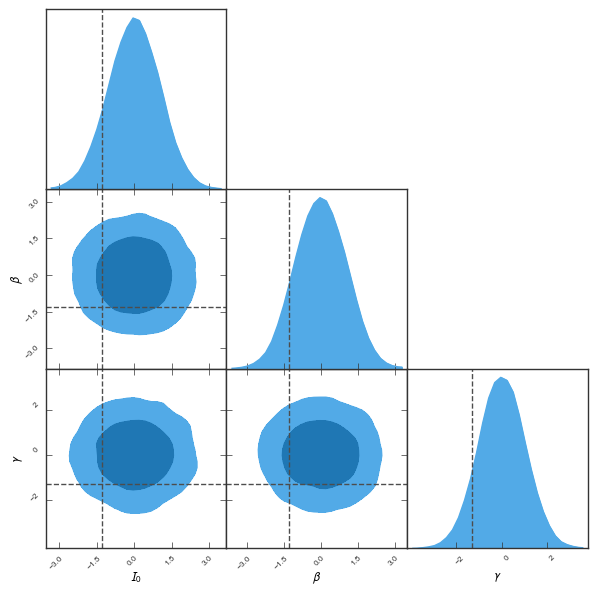

In [9]:
# Plot the inital flow:
flow = make_flow(len(true_parameters))
samples = flow.sample(10000)[0].cpu().detach().numpy()

pygtc.plotGTC([samples], truths=true_parameters.cpu().numpy(), figureSize=7, paramNames=[r"$I_0$", r"$\beta$", r"$\gamma$"]);

Let's also plot runs sampled from the untrained flow, to compare later with the trained flow.

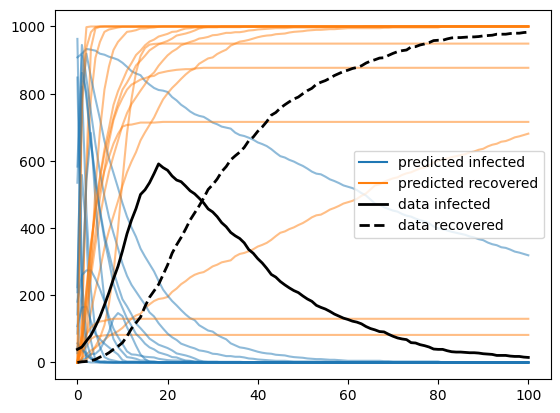

In [10]:
f, ax = plt.subplots()

for i in range(15):
    with torch.no_grad():
        sim_sir = sir.run_and_observe(flow.sample(1)[0][0])
    ax.plot(sim_sir[0].cpu().numpy(), color = "C0", alpha=0.5)
    ax.plot(sim_sir[1].cpu().numpy(), color = "C1", alpha=0.5)
    
ax.plot([], [], color = "C0", label = "predicted infected")
ax.plot([], [], color = "C1", label = "predicted recovered")
ax.plot(true_data[0].cpu(), color = "black", linewidth=2, label = "data infected")
ax.plot(true_data[1].cpu(), color = "black", linewidth=2, label = "data recovered", linestyle="--")
ax.legend()

### Train the flow

In [11]:
torch.manual_seed(0)

# Define a prior
prior = torch.distributions.MultivariateNormal(-2.0 * torch.ones(3, device=device), torch.eye(3, device=device))

optimizer = torch.optim.AdamW(flow.parameters(), lr=1e-3)

# We set the regularisation weight to 10.
w = 100

calibrator = Calibrator(model = sir,
                        posterior_estimator = flow,
                        prior=prior,
                        data=true_data,
                        optimizer=optimizer,
                        w=w,
                        n_samples_per_epoch=10,
                        log_tensorboard=True,
                        device=device
                       )

# and we run for 1000 epochs, stopping if the loss doesn't improve in 100 epochs.
calibrator.run(n_epochs=1000, max_epochs_without_improvement=100);

 27%|██████████████████████████████████████████████████▉                                                                                                                                         | 271/1000 [08:47<23:38,  1.95s/it, Forecast=6.76e+4, Reg.=590, total=6.82e+4, best loss=3.46e+3, epochs since improv.=100]


<Axes: >

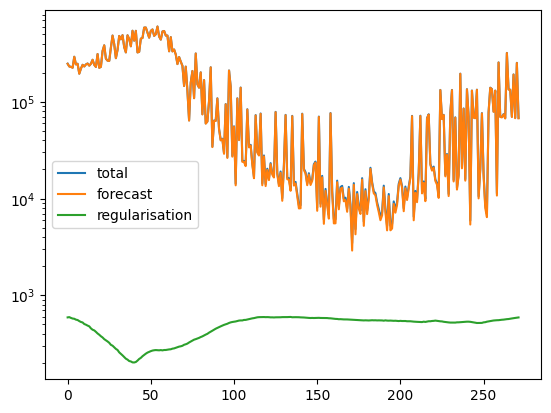

In [23]:
# Let's have a look at the loss over epochs:

df = pd.DataFrame(calibrator.losses_hist)
df.plot(logy=True)

In [13]:
# We can load the best model to check the results
flow.load_state_dict(calibrator.best_model_state_dict)

<All keys matched successfully>

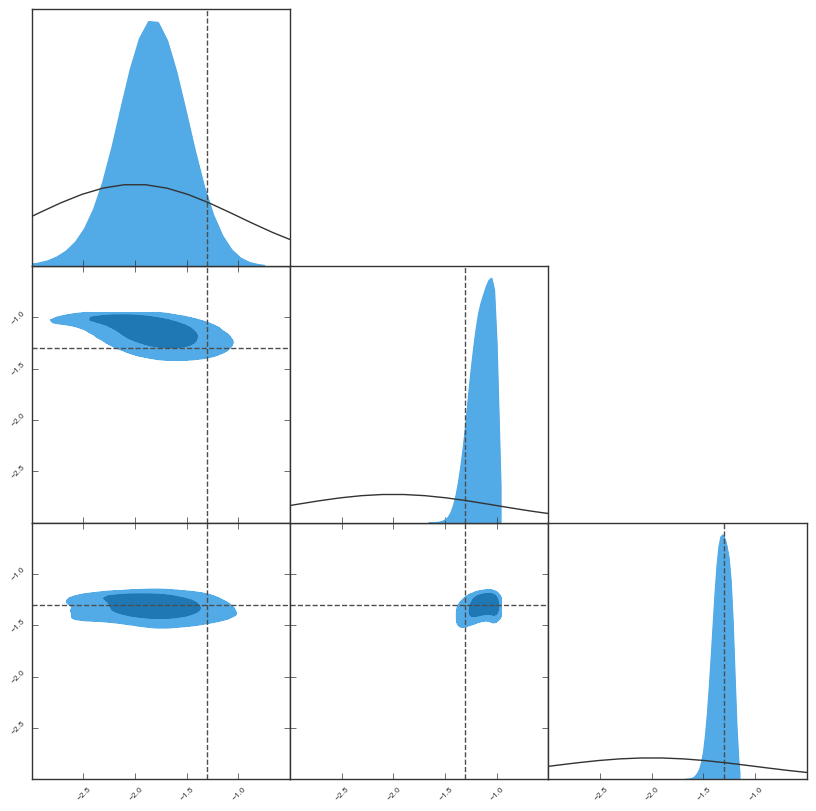

In [21]:
# Plot the final flow posterior approximator and compare it to the real parameters:
samples = flow.sample(50000)[0].detach().numpy()

#corner(samples, truths=true_parameters.numpy(), smooth=2, range = ((-2, -1.0), (-1.7, -1.0), (-1.4, -1.25)), labels=["initial_fraction_infected", r"$\beta$", r"$\gamma$"]);
#corner(samples, truths=true_parameters.numpy(), smooth=2, labels=["initial_fraction_infected", r"$\beta$", r"$\gamma$"]);
pygtc.plotGTC([samples], truths=true_parameters.numpy(), figureSize=10, priors=[(-2, 1) for i in range(3)], paramRanges=[(-3.0, -0.5) for i in range(3)]);

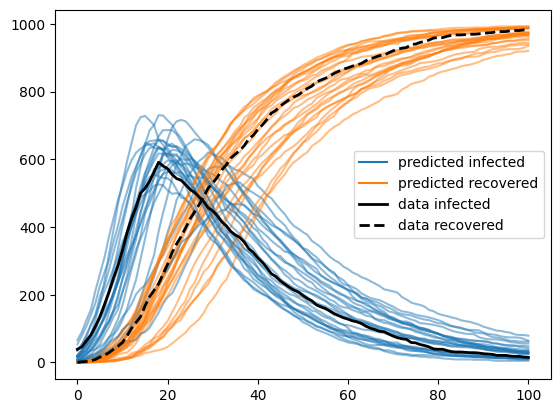

In [22]:
# compare the predictions to the synthetic data:

f, ax = plt.subplots()

for i in range(25):
    with torch.no_grad():
        sim_sir = sir.observe(sir.run((flow.sample(1)[0][0])))
    ax.plot(sim_sir[0].numpy(), color = "C0", alpha=0.5)
    ax.plot(sim_sir[1].numpy(), color = "C1", alpha=0.5)
    
ax.plot([], [], color = "C0", label = "predicted infected")
ax.plot([], [], color = "C1", label = "predicted recovered")
ax.plot(true_data[0], color = "black", linewidth=2, label = "data infected")
ax.plot(true_data[1], color = "black", linewidth=2, label = "data recovered", linestyle="--")

ax.legend()